# Single-photon Simulation
- The following notebook demonstrates the use of the emulator to simulate the propagation of a single photon in a quantum photonic processor.
- This can be used to find the unitary implemented by a system.
- First import required modules and some additional tools.

In [11]:
import lightworks as lw
from lightworks import emulator, State

from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from collections import Counter

- A general N is then defined, which is used to adjust the number of modes used for the circuit throughout the notebook.

In [12]:
N = 8

- Can then create a random unitary matrix which is programmed onto the chip.

In [13]:
U = lw.random_unitary(N)

circuit = lw.Unitary(U)

## Simulator
- First we try using the simulation part of the emulator. This allows the simulation of a number of input states, finding the probability amplitudes for the given outputs.
- To set this up, we specify the generated circuit to the simulator class. 

In [14]:
sim = emulator.Simulator(circuit)

- In this case we will choose to try to recreate the unitary matrix, which can be done by creating a list of all single photon input and output states.

In [15]:
states = []

# Create all single photon states by adding 1 to list when i=j, otherwise add 0
for i in range(N):
    state = []
    for j in range(N):
        if i == j:
            state += [1]
        else:
            state += [0]
    states.append(State(state))

# Calculate probability amplitude
results = sim.simulate(states, states)
U_calc = results.array

- The resultant matrix probability amplitude matrix can be visualized below, and we see that the unitary is correctly replicated.
- Note that the unitary needs to be transposed for the plotting below to show identical matrices.

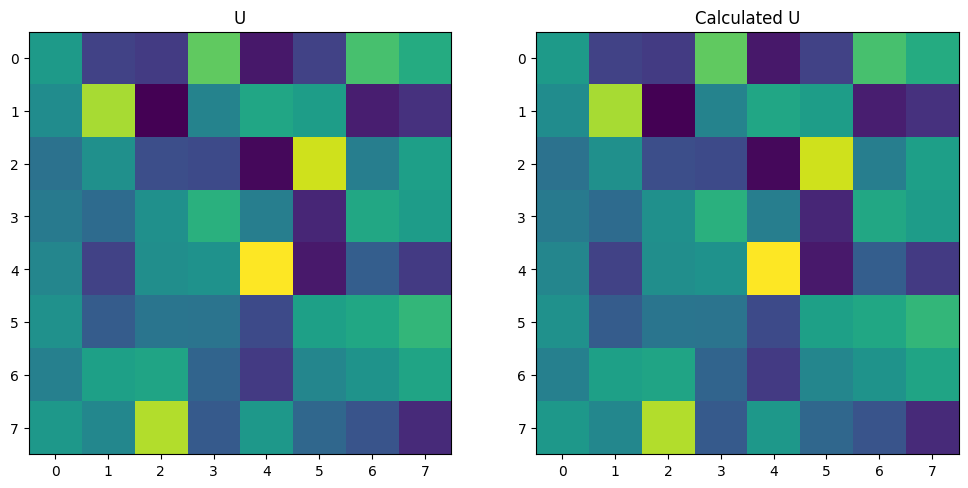

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].imshow(abs(U.T))
ax[1].imshow(abs(U_calc))
ax[0].set_title("U")
ax[1].set_title("Calculated U")

plt.show()

- It is also possible to directly view the probability amplitudes in a nicer form using the display_as_dataframe function included with the results object. 
- In this case the values are converted to probabilities with the conv_to_probability keyword.

In [17]:
results.display_as_dataframe(conv_to_probability = True)

,"|1,0,0,0,0,0,0,0>","|0,1,0,0,0,0,0,0>","|0,0,1,0,0,0,0,0>","|0,0,0,1,0,0,0,0>","|0,0,0,0,1,0,0,0>","|0,0,0,0,0,1,0,0>","|0,0,0,0,0,0,1,0>","|0,0,0,0,0,0,0,1>"
"|1,0,0,0,0,0,0,0>",0.160337,0.031275,0.026805,0.287558,0.008552,0.031536,0.255526,0.198412
"|0,1,0,0,0,0,0,0>",0.131128,0.370823,0.002644,0.113476,0.185122,0.165589,0.011114,0.020103
"|0,0,1,0,0,0,0,0>",0.085386,0.138220,0.041754,0.037857,0.004346,0.416142,0.105702,0.170593
"|0,0,0,1,0,0,0,0>",0.100004,0.076413,0.139672,0.210466,0.105578,0.014702,0.189331,0.163834
"|0,0,0,0,1,0,0,0>",0.118442,0.031625,0.135993,0.142504,0.478181,0.009012,0.058619,0.025624
"|0,0,0,0,0,1,0,0>",0.141216,0.056800,0.090067,0.088126,0.037843,0.173187,0.187620,0.225141
"|0,0,0,0,0,0,1,0>",0.109420,0.173324,0.181772,0.066240,0.025603,0.119427,0.144319,0.179895
"|0,0,0,0,0,0,0,1>",0.154069,0.121520,0.381292,0.053772,0.154776,0.070406,0.047768,0.016398


## Sampler
- The other way to use the emulator is as a sampler.
- This is achieved using the Sampler class, to which we provide the generated circuit and single input state that we want to look at. In this case we input a single photon on mode 0.

In [18]:
sampler = emulator.Sampler(circuit, State([1]+[0]*(N-1)))

- Once the sampler has been set up, we can then sample from it many times.
- The probability distribution was pre-calculated in the last step, so the sampling procedure takes place very quickly.
- We get the output state from the sample, and convert this into a mode number which is stored.

In [19]:
N_rep = 100 # Set number of samples
results = []

for i in range(N_rep):
    state = sampler.sample()
    # Get state from sampler and find which more the photon is on
    loc = state.s.index(1)
    results.append(loc)

# Count number of times we measure a photon on each mode
counted = Counter(results)

- The counts can then be converted into probabilities and compared to the expected values from the unitary.
- As we only choose to look at 100 samples here, the measured and expected distributions tend to vary as not enough samples have been taken to see convergence.

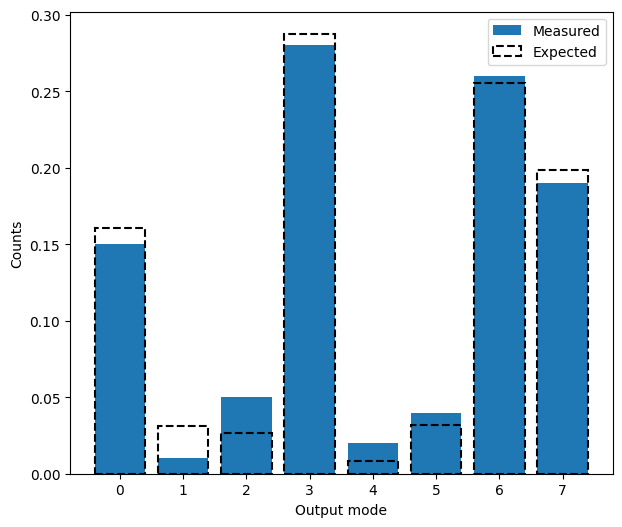

In [20]:
x = range(N)

# Convert counts to a list and normalise to total count numbers
p_calc = []
for i in x:
    p_calc.append(counted[i]/sum(counted.values()))

# Find expected distribution
p_exp = abs(U.T[0,:])**2

plt.figure(figsize = (7,6))
plt.bar(x, p_calc, label = "Measured", alpha = 1)
plt.bar(x, p_exp, label = "Expected", edgecolor = "Black", fill = False,
        linestyle = "dashed", linewidth = 1.5)
plt.xlabel("Output mode")
plt.ylabel("Counts")
plt.legend()
plt.show()